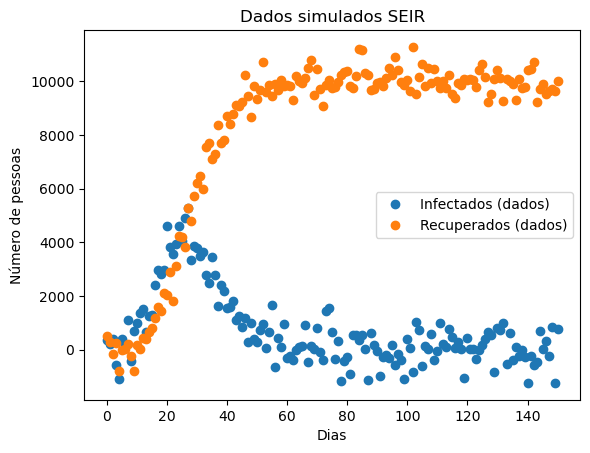

beta  real = 1.4000
sigma real = 0.2000 
gamma real = 0.1000


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import modelos_epidemiologicos as model


# Parâmetros reais que vamos tentar recuperar
beta_real = 1.4     # Taxa de transmissão
sigma_real = 1/5  # Inverso do período de incubação (5 dias)
gamma_real = 1/10  # Inverso do período infeccioso (10 dias)

N = 10000          # População total
I0 = 10            # Infectados iniciais
E0 = 5             # Expostos iniciais
R0 = 0             # Removidos iniciais
S0 = N - I0 - E0 - R0

# Sistema de equações SEIR
def seir(y, t, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

# Tempo
t = np.linspace(0, 150, 151)  # 101 pontos de 0 a 151 dias

# Resolver ODE para gerar dados verdadeiros
y0 = S0, E0, I0, R0
sol = odeint(seir, y0, t, args=(beta_real, sigma_real, gamma_real))
S, E, I, R = sol.T

# Adiciona um pequeno ruído nos dados (como se fossem medidas reais)
I_obs = I + 20*np.random.normal(5,30, size=I.shape)
R_obs = R + 15*np.random.normal(5,30,size=R.shape)

# Plotar os dados "observados"
plt.plot(t, I_obs, 'o', label='Infectados (dados)')
plt.plot(t, R_obs, 'o', label='Recuperados (dados)')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Número de pessoas')
plt.title('Dados simulados SEIR')
plt.show()

print(f'beta  real = {beta_real:.4f}\nsigma real = {sigma_real:.4f} \ngamma real = {gamma_real:.4f}')


In [35]:
from scipy.optimize import minimize

# Função para simular o modelo com parâmetros
def simulate_seir(t, beta, sigma, gamma):
    y0 = S0, E0, I0, R0
    sol = odeint(seir, y0, t, args=(beta, sigma, gamma))
    return sol.T

# Função de custo usando só I(t)
def cost_I(params):
    beta, sigma, gamma = params
    S_sim, E_sim, I_sim, R_sim = simulate_seir(t, beta, sigma, gamma)
    erro_I = np.sum((I_sim - I_obs)**2)
    erro_R = np.sum((R_sim - R_obs)**2)
    return erro_I +  erro_R

# Chute inicial para os parâmetros
initial_guess = [0.3, 1/6, 1/3]

# Otimizar
result_I = minimize(cost_I, initial_guess, bounds=[(0.3, 2), (0, 0.3), (0, 0.5)])
beta_fit_I, sigma_fit_I, gamma_fit_I = result_I.x

print('Ajuste usando apenas I(t):')
print(f'beta = {beta_fit_I:.4f}, sigma = {sigma_fit_I:.4f}, gamma = {gamma_fit_I:.4f}')


Ajuste usando apenas I(t):
beta = 1.6144, sigma = 0.1730, gamma = 0.0990


In [40]:
# Função de custo usando I(t) e R(t)
def cost_IR(params):
    beta, sigma, gamma = params
    S_sim, E_sim, I_sim, R_sim = simulate_seir(t, beta, sigma, gamma)
    erro_I = np.sum((I_sim - I_obs)**2)
    erro_R = np.sum((R_sim - R_obs)**2)
    return erro_I + erro_R

# Otimizar
result_IR = minimize(cost_IR, initial_guess, bounds=[(0.3, 2), (0, 0.3), (0, .3)])
beta_fit_IR, sigma_fit_IR, gamma_fit_IR = result_IR.x

print('Ajuste usando I(t) e R(t):')
print(f'beta = {beta_fit_IR:.4f}, sigma = {sigma_fit_IR:.4f}, gamma = {gamma_fit_IR:.4f}')


Ajuste usando I(t) e R(t):
beta = 1.4075, sigma = 0.2093, gamma = 0.0979


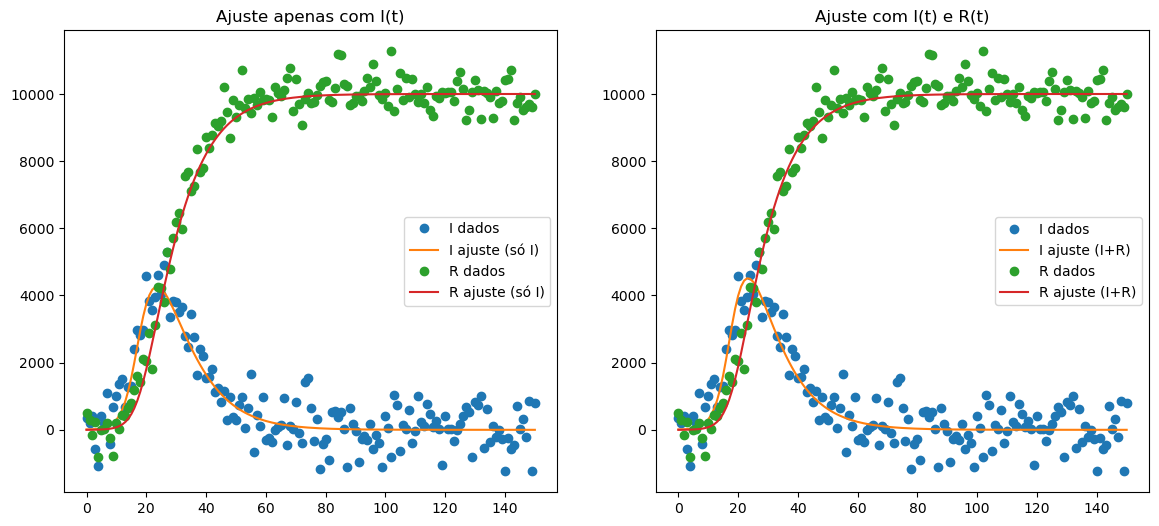

In [41]:
# Simulações para comparar
S_fit_I, E_fit_I, I_fit_I, R_fit_I = simulate_seir(t, beta_fit_I, sigma_fit_I, gamma_fit_I)
S_fit_IR, E_fit_IR, I_fit_IR, R_fit_IR = simulate_seir(t, beta_fit_IR, sigma_fit_IR, gamma_fit_IR)

# Plotar comparações
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, I_obs, 'o', label='I dados')
plt.plot(t, I_fit_I, '-', label='I ajuste (só I)')
plt.plot(t, R_obs, 'o', label='R dados')
plt.plot(t, R_fit_I, '-', label='R ajuste (só I)')
plt.title('Ajuste apenas com I(t)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, I_obs, 'o', label='I dados')
plt.plot(t, I_fit_IR, '-', label='I ajuste (I+R)')
plt.plot(t, R_obs, 'o', label='R dados')
plt.plot(t, R_fit_IR, '-', label='R ajuste (I+R)')
plt.title('Ajuste com I(t) e R(t)')
plt.legend()

plt.show()
